# Restoring a Noisy Image
> Written by David Mascharka

**This problem is *not* graded. The autograder will tell you if your solution is correct, but will not provide a hash. The solution notebook is available on EdX. **

## Understanding image restoration
In this problem, we will learn about a simple algorithm for removing noise from ('denoising') an image. We will want to use vectorization to write an efficient algorithm for this.

Suppose we have an image that we want to transmit to a friend. During transmission, there is a 10% chance that any given pixel gets distorted. After transmission, about 10% of our pixels have changed colors due to this distortion. For example, we might start with the image on the left and our friend may receive the image on the right:


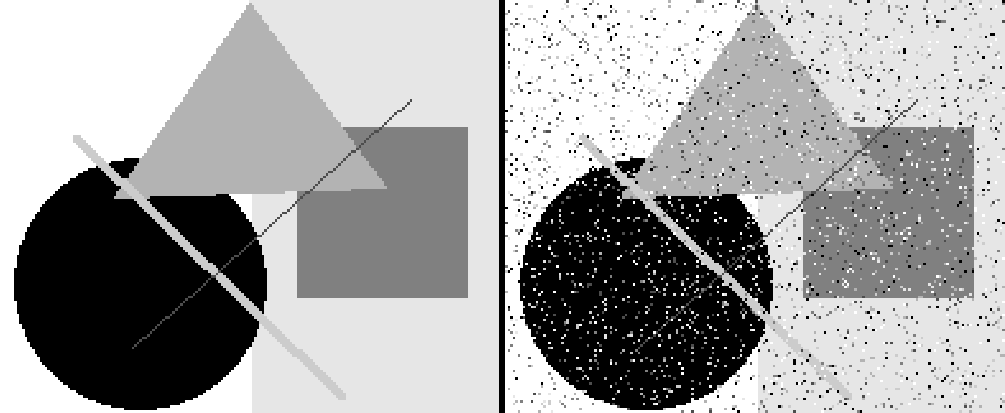

We want to write an algorithm that will automatically remove as much noise from the received image as possible. The algorithm we'll use for this is called Iterated Conditional Modes (ICM). We'll only concern ourselves with grayscale images for this, but note that the same technique can be applied to color images as well.

#### Iterated Conditional Modes 
The idea behind ICM is pretty straightforward. It hinges on a very simple observation: in an image, color changes are very infrequent. Objects tend to have the same color throughout them, so the only color differences we run into are when we transition from one object to another. For example, in the image above we see a color transition when we look at the boundary of the circle and the triangle. However, within an object the color is the same.

Taking a look at the noisy image, we can see that there are a lot of color changes; far more than in the original image. Most of these are isolated to a single pixel. For example, see this blowup of the triangle:

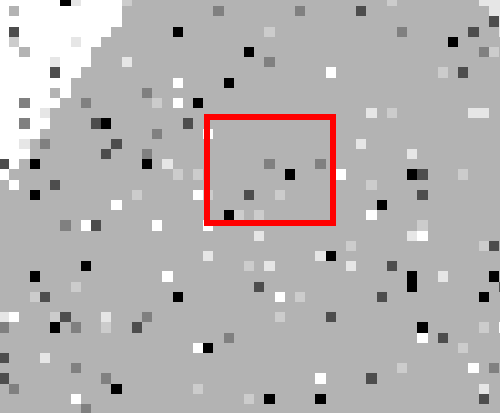

In the middle of the red rectangle we can see a dark gray pixel that's all by itself. We can be almost certain that this kind of discontinuity is caused by noise. The chances of a single pixel being a different color than all of its neighbors in a normal image is very low. If we change the color of that dark gray pixel to light gray, we'll probably improve the image quality.

This is exactly what the Iterated Conditional Modes algorithm does. We define the *energy* of a pixel $p$ as the number of $p$'s neighbors that differ in color from $p$.  We will define $p$'s neighborhood as the four pixels immediately adjacent to $p$. If $p$ is at $(3, 5)$, then $p$'s neighborhood is $\{(2, 5), (4, 5), (3, 4), (3, 6)\}$.
 
The energy of the whole image is the sum of each pixel's energy. The aim of the ICM algorithm is to minimize the energy of the noisy image by appropriately choosing color values for the most energetic pixels.

As you can probably tell by the name, *Iterated* Conditional Modes is an iterative algorithm. At each iteration, we change the color value of the highest-energy pixel to match the most neighbors it can.

Let's fix a concrete example. Suppose we're transmitting a 5x8 image that looks like this:

```
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
```

Not very interesting, but it illustrates our point. Suppose the transmitted image that our friend receives is:

```
                                0  0  0  0  1  1  0  1
                                0  1  0  0  1  1  1  1
                                0  0  0  0  0  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  1  0  1  1  1  1
```

We can compute the energy at each pixel by recording how many of the pixels above, below, left, and right are a different value. If we do this, we get these energy values:

```
                                0  1  0  1  1  1  3  1
                                1  4  1  1  2  0  1  0
                                0  1  0  1  3  1  0  0
                                0  0  1  1  2  0  0  0
                                0  1  3  2  1  0  0  0
```

Remeber, these are *energy* values, not *color* values. We'll pick the highest-energy pixel, which is at $(1, 1)$ and has energy 4. We change its color to minimize its energy. This is the value $0$. Flipping it yields the image:

```
                                0  0  0  0  1  1  0  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  0  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  1  0  1  1  1  1
```

We can now recompute the energy across the entire image and choose the next-highest value. Eventually, we reach a point where we don't swap any labels, and our algorithm terminates, yielding the restored image:

```
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
```

which perfectly restores what we transmitted. Note that in general, the restoration will not be perfect. For an example of an imperfect restoration, if we get this transmission:

```
                                0  0  0  0  1  1  1  1
                                0  1  1  0  1  1  1  1
                                0  1  1  0  1  1  1  1
                                0  0  0  0  1  1  1  1
                                0  0  0  0  1  1  1  1
```

we will not remove that block of $1$s in the middle of the $0$s.

## Problem 1: Local energy of each pixel
Write a Python function that takes in a 2-dimensional NumPy array containing color values, and returns the energy at each pixel in the image. Recall that the energy of a pixel is the number of a pixel's neighbors that differ from it.

Hint: the vectorized solution to the heat equation problem can be easily adapted to compute the energy at each pixel.

Fun fact: `True` and `False` can be interpreted as integers! A `True` value is a binary 1, while `False` is binary 0. We can use this fact to help with our vectorization. Try it out!

```
>>> np.sum([False, True, False])
1
```

In [13]:
import numpy as np

def compute_energy(img):
    ''' Given a 2D array of color values, produces a 2D array with
        the energy at each pixel, where energy is defined as the sum
        of each's pixels neighbors differing in color from that pixel.
    
        Parameters
        ----------
        img : numpy.ndarray, shape=(M, N)
            An MxN array of color values.

        Returns
        -------
        numpy.ndarray, shape=(M, N)
            An MxN array of energy values.
    '''
    ret = np.zeros_like(img);
    ret[:-1,:] += (img[:-1,:]!=img[1:,:]);
    ret[1:,:] += (img[1:,:]!=img[:-1,:]);
    ret[:,:-1] += (img[:,:-1]!=img[:,1:]);
    ret[:,1:] += (img[:,1:]!=img[:,:-1]);
    return ret;
    # student code goes here

In [14]:
from bwsi_grader.python.image_restoration import grader1
grader1(compute_energy)

Please note that these problem are *not* graded. The autograder will tell you if your solution is correct, but will not provide a hash.The solution notebook is available on EdX.

============================== ALL TESTS PASSED! ===============================
                                  Great Job!



## Problem 2: Neighbor colors
Once we get the highest-energy pixel, we need to get the color values of its neighbors, so we know what color will minimize the energy. Write a Python function that takes in a 2D NumPy array of color values and (row, column) coordinates of a pixel, and returns a list containing the color values of $(r, c)$'s neighbors.

In [15]:
def get_neighbor_colors(img, pixel):
    ''' Given a 2D array of color values and the position of a pixel,
        returns a list of `pixel`'s neighboring color values.
    
    Parameters
    ----------
    img : numpy.ndarray, shape=(M, N)
        An MxN array of color values
    pixel : tuple[int, int]
        The (r, c) index of the pixel whose neighbors to retrieve.
        
    Returns
    -------
    List[int]
        The color (or label) value of each of `pixel`'s neighbors.
    '''
    # student code goes here
    ret = [];
    r,c = pixel;
    m,n = np.shape(img);
    if (r > 0): ret.append(img[r-1,c]);
    if (r < m-1): ret.append(img[r+1,c]);
    if (c > 0): ret.append(img[r,c-1]);
    if (c < n-1): ret.append(img[r,c+1]);
    return ret;
        

In [16]:
from bwsi_grader.python.image_restoration import grader2
grader2(get_neighbor_colors)


============================== ALL TESTS PASSED! ===============================
                                  Great Job!



## Problem 3: Iterated Conditional Modes
With these two functions in place, we can implement Iterated Conditional Modes. Write a Python function takes as input a 2D NumPy array of color values and returns a new image with the highest-energy pixel replaced.

Your function should:
 - Use the `compute_energy` function to get the energy at each pixel
 - Find the pixel coordinates of the highest-energy pixel (*hint: NumPy's argmax may be useful*)
 - Use the `get_neighbor_colors` function to get the colors of the highest-energy pixel's neighbors
 - Change the highest-energy pixel color to best match its neighbors

In [35]:
def denoise_iter(noisy):
    ''' Given a 2D array of color values, performs one step of the
        Iterated Conditional Modes algorithm, changing the color of
        the highest-energy pixel.

        Parameters
        ---------
        noisy : numpy.ndarray, shape=(M, N)
            An MxN array of color values.

        Returns
        -------
        numpy.ndarray, shape=(M, N)
            An MxN array of color values, after applying one step of ICM.
    '''
    # student code goes here
    energies = compute_energy(noisy);
    M,N = np.shape(energies);
    cell = np.argmax(energies);
    R,C = cell//N,cell%N 
    neighbors = get_neighbor_colors(noisy,(R,C));
    values, counts = np.unique(neighbors,return_counts=True);
    ret = np.copy(noisy);
    ret[R,C] = values[np.argmax(counts)];
    return ret;

In [36]:
from bwsi_grader.python.image_restoration import grader3
grader3(denoise_iter)


============================== ALL TESTS PASSED! ===============================
                                  Great Job!



Now we'll see your functions in action. Let's generate a noisy image.

<IPython.core.display.Javascript object>


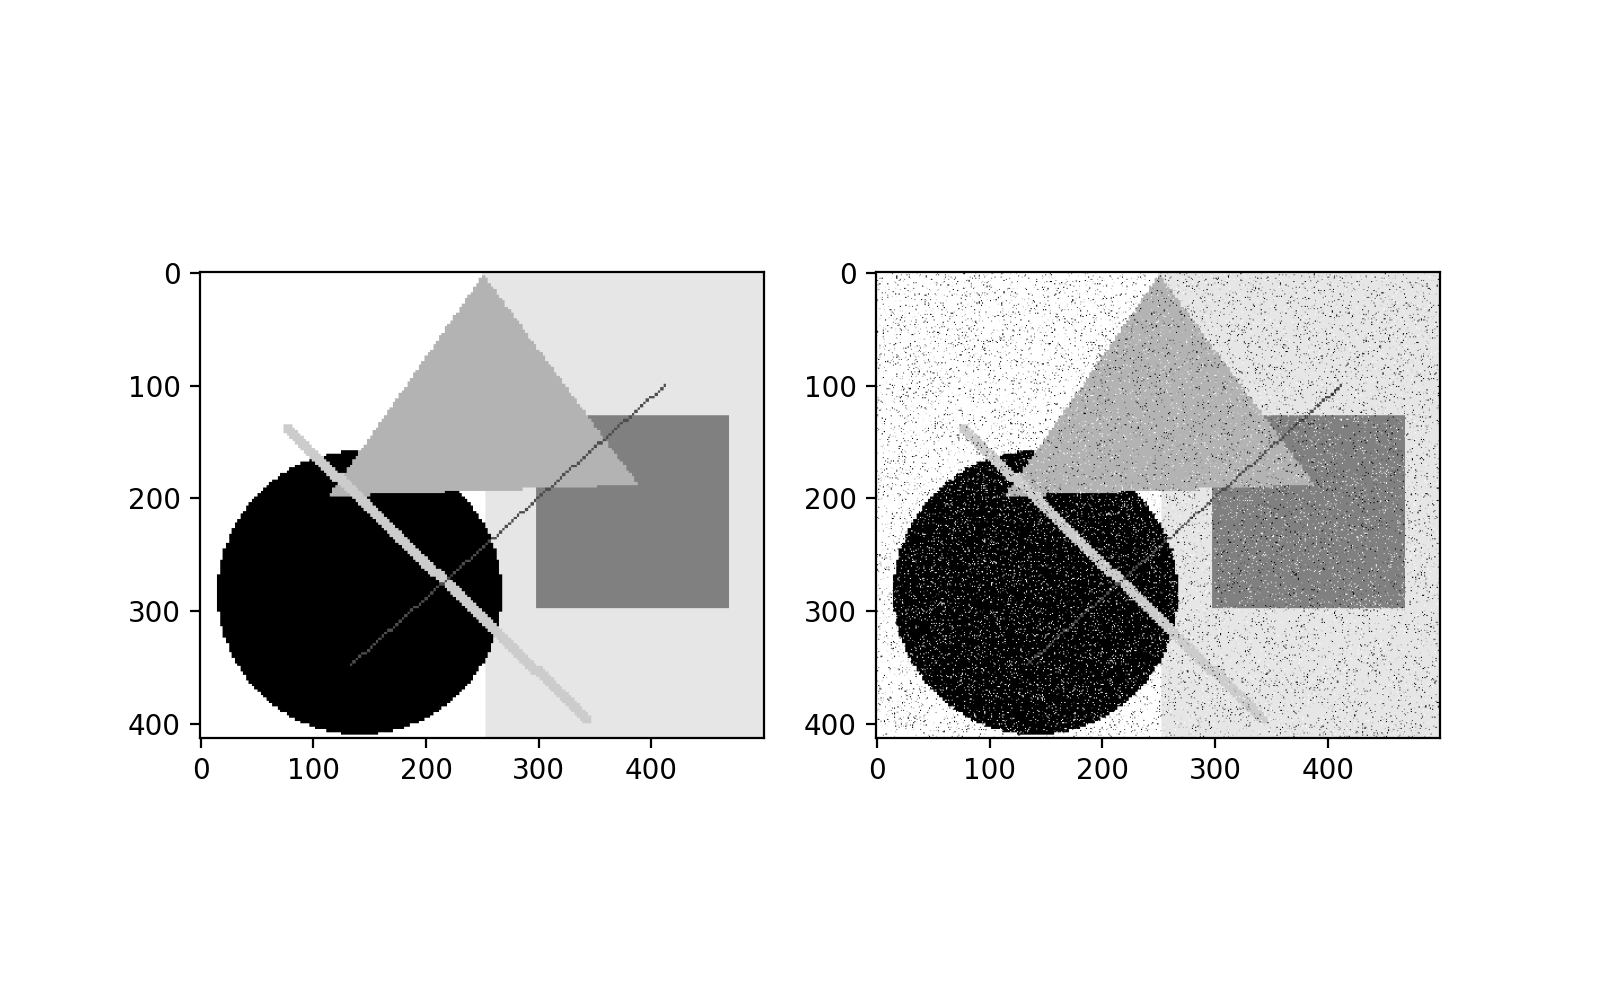

In [37]:
# This cell generates a noisy image and displays it
# You need not modify this code, simply run the cell

import matplotlib.pyplot as plt
%matplotlib notebook

def generate_noisy_copy(img, pct_noise):
    ''' Given a 2D array of color values and an approximate noise percentage,
        returns a noisy image.
    
        Parameters
        ----------
        img : numpy.ndarray, shape=(M, N)
            An MxN array of color values -- the pristine image.
        pct_noise : float
            The amount of noise to add, as an approximate percentage.

        Returns
        -------
        numpy.ndarray, shape=(M, N)
            An MxN array of color values -- a noisy copy of the pristine image.
    '''
    # create a noise image built by randomly choosing a color from our image
    noise = np.random.choice(np.unique(img), img.shape).astype(np.uint8)
    # make a random choice for each pixel, as to whether to draw that pixel from 
    # the `noise` image or from input image
    rands = np.random.rand(img.size).reshape(img.shape)
    
    # start with a copy of the pristine image and distort it
    noisy = img.copy()
    idxs_to_change = np.where(rands < pct_noise)
    noisy[idxs_to_change] = noise[idxs_to_change]
    
    return noisy

# load the original image
pristine = (plt.imread('original-image.png')*255).astype(np.uint8)

# add about 10% noise
noisy = generate_noisy_copy(pristine, 0.1)

# display the images
fig, axs = plt.subplots(1, 2, figsize=(8, 5))
axs[0].imshow(pristine, 'gray')
axs[1].imshow(noisy, 'gray')

With all the code in place, let's finally denoise our image!

In [38]:
# You may simply run this cell

num_iters = 0                    # how many iterations we have performed, to see progress
cleaned_up = noisy.copy()        # the denoised image
old = np.zeros_like(cleaned_up)  # the previous iteration, for a stopping condition
while np.any(old != cleaned_up): # loop until no labels change values
    num_iters += 1
    if (num_iters%1000) == 0:    # print progress
        print(num_iters, 'Energy {}'.format(compute_energy(cleaned_up).sum()))
    old = cleaned_up.copy()
    cleaned_up = denoise_iter(cleaned_up)

1000 Energy 134820
2000 Energy 127134
3000 Energy 119496
4000 Energy 111854
5000 Energy 104186
6000 Energy 96570
7000 Energy 88932
8000 Energy 81396
9000 Energy 73812
10000 Energy 66166
11000 Energy 58554
12000 Energy 50962
13000 Energy 43370
14000 Energy 35728
15000 Energy 28094
16000 Energy 20506
17000 Energy 13636


Display the noisy version, our denoised image, and the original alongside each other

<IPython.core.display.Javascript object>


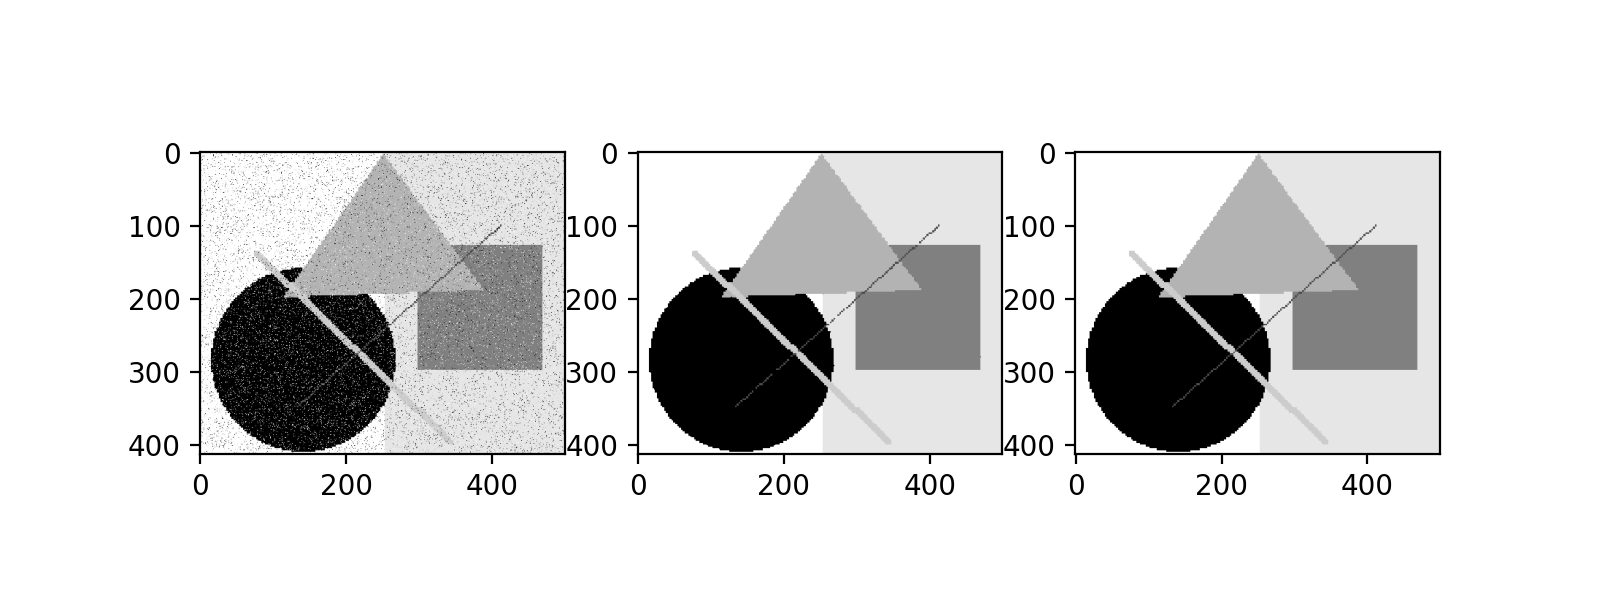

In [39]:
# Again, you only need to run this

fig, axs = plt.subplots(1, 3, figsize=(8, 3))
axs[0].imshow(noisy, 'gray')
axs[1].imshow(cleaned_up, 'gray')
axs[2].imshow(pristine, 'gray')

Now we can see the difference in energy between the original and denoised version

In [40]:
compute_energy(cleaned_up).sum()

8924

In [41]:
compute_energy(pristine).sum()

9048